In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
import glob
import yahist
from matplotlib.collections import LineCollection

In [2]:
yahist.utils.set_default_style()

In [3]:
fname = "../sources/1point3acres/data/cases_and_deaths.json.gz"
df_total = pd.read_json(fname)
df_total["date"] = pd.to_datetime(df_total["date"])
df_total = df_total.sort_values(["date"])

# drop cruise ship stuff
df_total = df_total[
    (df_total["state"].str.len() == 2)
    & (df_total["county"].str.strip().str.len() > 0)
]

df_total["place"] = df_total["county"].str.cat(df_total["state"], sep=", ")
df_cases = df_total.query("not is_death").reset_index(drop=True)
df_counties = df_cases.groupby(["date","place"])["state"].count().unstack(1).fillna(0).astype(int).sort_index().cumsum()
df_states = df_cases.groupby(["date","state"])["state"].count().unstack(1).fillna(0).astype(int).sort_index().cumsum()

In [76]:
def plot(max_date="2020-03-26", regions="states", frac=1.0, fname=None):
     # frac = 1.0 means take the latest point, 0.0 means take the previous point
    if regions == "states":
        dfcurr = df_states
    if regions == "counties":
        dfcurr = df_counties
    dfdiff = dfcurr.diff()
    
    prev_date = str(pd.Timestamp(max_date)-pd.Timedelta("1 day")).split()[0]

    lines = []
    for place in dfcurr.columns:
        cases = dfcurr[place].loc[:max_date]
        newcases = dfdiff[place].loc[:max_date]
        line = np.array(np.c_[cases,newcases][1:,:])
        line[-1] = frac*line[-1] + (1-frac)*line[-2]
        lines.append(line)

    lc = LineCollection(lines, color="gray", lw=1, alpha=0.3)

    fig, ax = plt.subplots()
    ax.add_collection(lc)
    xs = frac*dfcurr.loc[max_date] + (1-frac)*dfcurr.loc[prev_date]
    ys = frac*dfdiff.loc[max_date] + (1-frac)*dfdiff.loc[prev_date]
    ax.scatter(xs,ys,s = 8.0,color="black",alpha=0.6)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1,1e5])
    ax.set_ylim([1,1e5])
    ax.set_xlabel("current cumulative cases")
    ax.set_ylabel("new cases (daily)")
    ax.set_title(f"cases in {regions} up to {max_date}")
    ax.grid(alpha=0.25)
    
    if fname:
        fig.savefig(fname)
        plt.close()


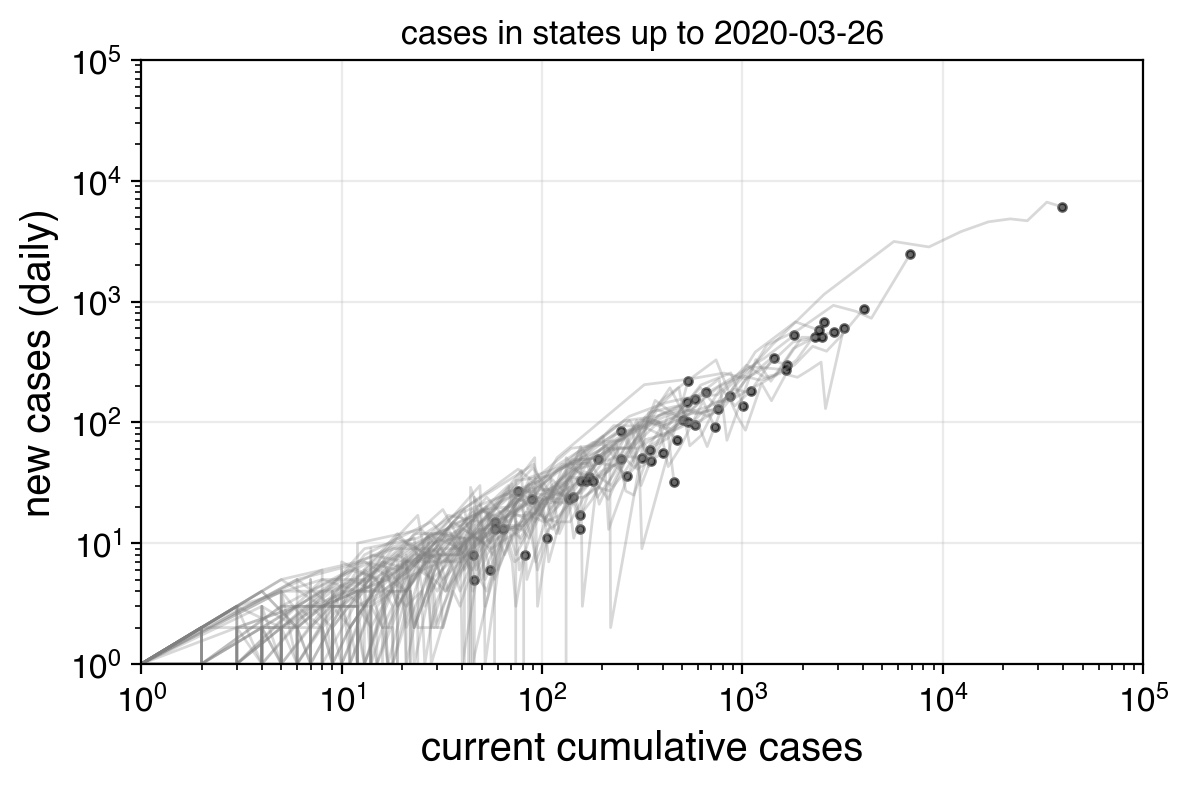

In [77]:
plot(max_date=f"2020-03-26", regions="states", frac=1.0)

In [78]:
!mkdir -p plot_trajectories/
!rm plot_trajectories/*.png

regions = "states"
# regions = "counties"

for i in range(2,26+1):
# for i in range(2,4+1):
    day = str(i).zfill(2)
    for frac in np.linspace(0,0.9,10):
        # frac 0 does the previous day, so we start with 0.0 to 0.9, then 
        # when i increments, it's the next day
        ifrac = int(frac*10)
        fname = f"plot_trajectories/plot_{day}{ifrac}.png"
        print(fname)
        plot(max_date=f"2020-03-{day}", frac=frac, regions=regions, fname=fname)

# !ffmpeg -y -r 5 -f image2 -i plot_trajectories/plot_%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p trajectories_{regions}.mp4
# !web trajectories_{regions}.mp4

plot_trajectories/plot_020.png
plot_trajectories/plot_021.png
plot_trajectories/plot_022.png
plot_trajectories/plot_023.png
plot_trajectories/plot_024.png
plot_trajectories/plot_025.png
plot_trajectories/plot_026.png
plot_trajectories/plot_027.png
plot_trajectories/plot_028.png
plot_trajectories/plot_029.png
plot_trajectories/plot_030.png
plot_trajectories/plot_031.png
plot_trajectories/plot_032.png
plot_trajectories/plot_033.png
plot_trajectories/plot_034.png
plot_trajectories/plot_035.png
plot_trajectories/plot_036.png
plot_trajectories/plot_037.png
plot_trajectories/plot_038.png
plot_trajectories/plot_039.png
plot_trajectories/plot_040.png
plot_trajectories/plot_041.png
plot_trajectories/plot_042.png
plot_trajectories/plot_043.png
plot_trajectories/plot_044.png
plot_trajectories/plot_045.png
plot_trajectories/plot_046.png
plot_trajectories/plot_047.png
plot_trajectories/plot_048.png
plot_trajectories/plot_049.png
plot_trajectories/plot_050.png
plot_trajectories/plot_051.png
plot_tra

In [79]:
!ffmpeg -y -r 25 -f image2 -pattern_type glob -i 'plot_trajectories/*.png'  -vcodec libx264 -crf 15  -pix_fmt yuv420p trajectories_{regions}.mp4
!web trajectories_{regions}.mp4

ffmpeg version 4.1.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with Apple LLVM version 10.0.0 (clang-1000.11.45.5)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.1.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags='-I/Library/Java/JavaVirtualMachines/openjdk-11.0.2.jdk/Contents/Home/include -I/Library/Java/JavaVirtualMachines/openjdk-11.0.2.jdk/Contents/Home/include/darwin' --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libtesseract --enable-libtheora --enable-libvorbis --enable-libvpx --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-videotoolbox --disa

In [80]:
from IPython.display import HTML
HTML(f"""
    <video alt="test" controls autoplay>
        <source src="trajectories_{regions}.mp4" type="video/mp4">
    </video>
""")